1. Definir as bibliotecas Python

In [1]:
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import ast

2. Carregar o dataset de ratings e info sobre os filmes

In [2]:
try:
    movie_data_df = pd.read_csv(
        'movie_data.csv',
        encoding='ISO-8859-1',
        quotechar='"',
        sep=',',
        engine='python'
    )
    print("Dataset de metadados de filmes (movie_data) carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'movie_data.csv' não encontrado.")
    exit()

Dataset de metadados de filmes (movie_data) carregado com sucesso.


In [3]:
print(movie_data_df.head(5))

                        _id                 genres  \
0  5fc85f606758f69634496fd3  ["Music","Animation"]   
1  5fc85ff26758f696344ace0c                     []   
2  5fc85f606758f69634496fcd              ["Drama"]   
3  5fc85f606758f69634496fd1              ["Drama"]   
4  5fc85f606758f69634496fd4        ["Documentary"]   

                                           image_url    imdb_id  \
0  film-poster/4/6/4/4/4/0/464440-football-freaks...        NaN   
1  film-poster/2/4/5/5/0/0/245500-aftermath-0-230...  tt0586129   
2  film-poster/9/3/3/1/8/93318-where-chimneys-are...  tt0045731   
3                                                NaN  tt0187327   
4  film-poster/4/5/4/6/0/3/454603-50-years-of-fab...  tt4769914   

                                         imdb_link                 movie_id  \
0                                              NaN          football-freaks   
1  http://www.imdb.com/title/tt0586129/maindetails           aftermath-1960   
2  http://www.imdb.com/title/tt0045

In [4]:
try:
    ratings_df = pd.read_csv(
        'ratings_export.csv',
        encoding='ISO-8859-1',
        quotechar='"',
        sep=',',
        engine='python'
    )
    print("Dataset de metadados de filmes (ratings_export) carregado com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivo 'ratings_export.csv' não encontrado.")
    exit()

print(ratings_df.head(5))

Dataset de metadados de filmes (ratings_export) carregado com sucesso.
                        _id          movie_id  rating_val     user_id
0  5fc57c5d6758f6963451a07f        feast-2014           7  deathproof
1  5fc57c5d6758f6963451a063       loving-2016           7  deathproof
2  5fc57c5d6758f6963451a0ef  scripted-content           7  deathproof
3  5fc57c5d6758f6963451a060        the-future           4  deathproof
4  5fc57c5c6758f69634519398              mank           5  deathproof


In [5]:
# Total de linhas antes da filtragem
print(f"Total de linhas antes da filtragem: {len(ratings_df)}")

# Contagem de quantas vezes cada filme aparece
movie_counts = ratings_df['movie_id'].value_counts()

# Mantendo apenas filmes com pelo menos 1000 ratings
valid_movies = movie_counts[movie_counts >= 1000].index

# Filtrando o df
filtered_df = ratings_df[ratings_df['movie_id'].isin(valid_movies)]

# Total de linhas depois da filtragem
print(f"Total de linhas depois da filtragem: {len(filtered_df)}")

Total de linhas antes da filtragem: 11078167
Total de linhas depois da filtragem: 4885108


3. Tratamento e Preparação dos Dados de Filmes (movie_data_df)

a) Garantir que a coluna 'id' exista e seja do tipo string para o join

In [6]:
if 'movie_id' not in movie_data_df.columns:
    print("Erro: A coluna 'movie_id' não foi encontrada em 'movie_data.csv'. Esta coluna é necessária para o join.")
    exit()
movie_data_df['movie_id'] = movie_data_df['movie_id'].astype(str)

b) Tratar a coluna 'genres'.

In [7]:
#    Converte strings como "['Horror', 'Thriller']" para listas reais.
#    Se já for uma lista, mantém como está.
if not movie_data_df.empty and 'genres' in movie_data_df.columns:
    def parse_genres(genre_data):
        if isinstance(genre_data, str) and genre_data.startswith('[') and genre_data.endswith(']'):
            try:
                return ast.literal_eval(genre_data)
            except (ValueError, SyntaxError):
                return [] # Retorna lista vazia em caso de erro de parsing
        elif isinstance(genre_data, list):
            return genre_data # Já é uma lista
        return [] # Default para outros tipos ou formatos inválidos

    movie_data_df['genres'] = movie_data_df['genres'].apply(parse_genres)
else:
    print("Aviso: Coluna 'genres' não encontrada ou movie_data_df está vazio. A filtragem por gênero pode não funcionar.")
    # Adicionar uma coluna 'genres' vazia para evitar erros se ela não existir
    if 'genres' not in movie_data_df.columns:
         movie_data_df['genres'] = pd.Series([[] for _ in range(len(movie_data_df))])


c) Garantir que a coluna 'runtime' exista, seja numérica e tratar valores ausentes/inválidos

In [8]:
if 'runtime' not in movie_data_df.columns:
    print("Erro: A coluna 'runtime' não foi encontrada em 'movie_data.csv'. Esta coluna é necessária para a filtragem.")
    exit()
movie_data_df['runtime'] = pd.to_numeric(movie_data_df['runtime'], errors='coerce')
movie_data_df.dropna(subset=['runtime'], inplace=True) # Remove filmes onde runtime não pôde ser convertido para número

d) Filtrar movie_data_df: gênero "Romance" (case-insensitive) E run_time >= 60

In [9]:
#    A função de parse_genres já garante que 'genres' seja uma lista.
filtered_movie_data = movie_data_df[
    movie_data_df['genres'].apply(lambda genre_list: isinstance(genre_list, list) and \
                                  any('romance' == genre.lower() for genre in genre_list if isinstance(genre, str))) &
    (movie_data_df['runtime'] >= 60)
]

if filtered_movie_data.empty:
    print("Nenhum filme encontrado nos metadados que satisfaça os critérios (romance, runtime >= 60 min).")
    print("O modelo KNN não terá dados de filmes para processar se continuar com este filtro.")

print(f"Número de filmes após filtragem por metadados (romance, >=60min): {len(filtered_movie_data)}")

print(filtered_movie_data.head(5))

Número de filmes após filtragem por metadados (romance, >=60min): 19209
                         _id                               genres  \
5   5fc85ff26758f696344ace3a                            [Romance]   
14  5fc85ff26758f696344acf40                  [Romance, TV Movie]   
40  5fc85ff26758f696344acf8d                    [Comedy, Romance]   
46  5fc85ff26758f696344ad0b1  [Action, Comedy, Thriller, Romance]   
57  5fc85ff26758f696344ace55          [Adventure, Romance, Crime]   

                                            image_url    imdb_id  \
5   film-poster/5/6/1/5/2/56152-where-love-has-gon...  tt0058745   
14  film-poster/6/7/7/6/5/67765-desperately-seekin...  tt1967688   
40  film-poster/3/9/1/0/3/39103-say-it-isn-t-so-0-...  tt0239949   
46  film-poster/2/6/6/9/0/26690-killers-0-230-0-34...  tt1103153   
57  film-poster/4/1/9/0/8/4/419084-crime-over-lond...  tt0027476   

                                          imdb_link  \
5   http://www.imdb.com/title/tt0058745/maindetai

4. Juntar ratings_df com filtered_movie_data

In [10]:
merged_df = pd.merge(ratings_df, filtered_movie_data, on="movie_id", how="inner")

if merged_df.empty:
    print("Após o join com os filmes filtrados, não restaram avaliações.")
    print("O modelo KNN não pode ser construído. Verifique os filtros, os dados de filmes e as avaliações.")
    exit()

print(f"Número de avaliações após o join com filmes filtrados: {merged_df.shape[0]}")

Número de avaliações após o join com filmes filtrados: 1382877


5. Filtrando por filmes avaliados por usuários que fizeram mais de 1000 reviews

In [11]:
# Contagem de quantas vezes cada movie_id aparece
movie_counts = merged_df['movie_id'].value_counts()

# Apenas movies com pelo menos 1000 avaliações
valid_movies = movie_counts[movie_counts >= 1000].index

# Filtrando o DataFrame
filtered_df = merged_df[merged_df['movie_id'].isin(valid_movies)]

# Total de linhas antes da filtragem
print(f"Total de linhas antes da filtragem: {len(filtered_df)}")

## Aplicando 

# Contagem de quantas vezes cada user_id aparece
user_counts = merged_df['user_id'].value_counts()

# Apenas users com pelo menos 1000 avaliações
valid_users = user_counts[user_counts >= 1000].index

# Filtrando o DataFrame
filtered_df = merged_df[merged_df['user_id'].isin(valid_users)]

# Total de linhas depois da filtragem
print(f"Total de linhas depois da filtragem: {len(filtered_df)}")

Total de linhas antes da filtragem: 547771
Total de linhas depois da filtragem: 150560


6. Construção da matriz usuário-filme

In [12]:
# Agrupar por (user_id, movie_id) e calcular média de rating
ratings_grouped = filtered_df.groupby(['user_id', 'movie_id'])['rating_val'].mean().reset_index()

# Mapear user_id e movie_id para índices
user_to_index = {uid: idx for idx, uid in enumerate(ratings_grouped['user_id'].unique())}
movie_to_index = {mid: idx for idx, mid in enumerate(ratings_grouped['movie_id'].unique())}

ratings_grouped['user_idx'] = ratings_grouped['user_id'].map(user_to_index)
ratings_grouped['movie_idx'] = ratings_grouped['movie_id'].map(movie_to_index)

# Criar matriz esparsa (usuarios x filmes)
n_users = len(user_to_index)
n_movies = len(movie_to_index)
matrix = csr_matrix((ratings_grouped['rating_val'], 
                     (ratings_grouped['user_idx'], ratings_grouped['movie_idx'])), 
                    shape=(n_users, n_movies))

print(f"Matriz de dimensão {matrix.shape} criada com sucesso.")

Matriz de dimensão (99, 15111) criada com sucesso.


7. Método do cotovelo para ajustar k

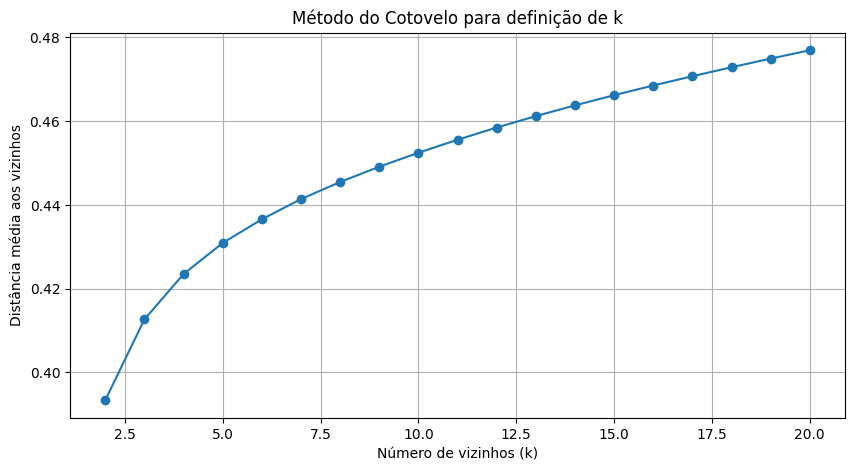

In [13]:
distances = []
k_range = range(2, 21)

for k in k_range:
    knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn.fit(matrix)
    dists, _ = knn.kneighbors(matrix)
    mean_distance = np.mean(dists[:, 1:])  # Exclui o 0 (autovizinho)
    distances.append(mean_distance)

plt.figure(figsize=(10, 5))
plt.plot(k_range, distances, marker='o')
plt.title('Método do Cotovelo para definição de k')
plt.xlabel('Número de vizinhos (k)')
plt.ylabel('Distância média aos vizinhos')
plt.grid(True)
plt.show()


8. Redução de Dimensionalidade com SVD

In [14]:
svd = TruncatedSVD(n_components=10)
matrix_reduced = svd.fit_transform(matrix)

print("Dimensão original:", matrix.shape)
print("Dimensão após SVD:", matrix_reduced.shape)


Dimensão original: (99, 15111)
Dimensão após SVD: (99, 10)


9. Aplicação das métricas RMSE, MAE e SSE

In [15]:
# Avaliação Detalhada do Modelo começa aqui
print("\n--- Iniciando Avaliação Detalhada do Modelo ---")

# 1. Separar os dados em treino e teste
# filtered_df é o DataFrame com 150560 linhas após todas as filtragens (genre = romance, runtime >= 60, filmes e usuários com mais de 1000 avaliações).
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42) #

k_neighbors_eval = 7  # K para o KNN na avaliação, baseado no método do cotovelo. Aqui poderíamos ter tentando outros valores, mas limitações de hardware nos impediram.
n_svd_components_eval = 10 # Número de componentes para SVD na avaliação.

# DataFrame para armazenar os resultados da avaliação
results_list = []


--- Iniciando Avaliação Detalhada do Modelo ---


10. Selecionando as métricas

In [16]:
scenarios = []
metrics_to_test = ['cosine', 'euclidean'] # Métricas de similaridade escolhidas

for metric_name in metrics_to_test:
    scenarios.append({'name': f'KNN Original - Métrica: {metric_name}', 
                      'use_svd': False, 
                      'metric': metric_name})
    scenarios.append({'name': f'KNN com SVD - Métrica: {metric_name}', 
                      'use_svd': True, 
                      'metric': metric_name})

print("Métricas criadas.")

Métricas criadas.


11. Rodando o KNN e Resultados

In [17]:
for scenario in scenarios:
    print(f"\nAvaliando cenário: {scenario['name']}")
    
    y_true = []
    y_pred = []
    
    try:
        train_user_item_matrix = train_df.pivot(index='user_id', 
                                                columns='movie_id', 
                                                values='rating_val').fillna(0)
        if train_user_item_matrix.empty:
            print("  Matriz de treino usuário-item está vazia. Pulando cenário.")
            continue
    except Exception as e:
        print(f"  Erro ao criar matriz de treino para o cenário: {e}. Pulando.")
        continue

    knn_model = NearestNeighbors(n_neighbors=k_neighbors_eval, 
                                 metric=scenario['metric'], 
                                 algorithm='brute')
    
    svd_transformer = None 

    if scenario['use_svd']:
        if train_user_item_matrix.shape[1] < n_svd_components_eval:
            print(f"  Número de filmes na matriz de treino ({train_user_item_matrix.shape[1]}) é menor que n_components SVD ({n_svd_components_eval}). Pulando cenário SVD.")
            results_list.append({'Cenário': scenario['name'], 'RMSE': np.nan, 'MAE': np.nan, 'SSE': np.nan, 'Num_Predições': 0, 'Comentário': 'Menos filmes que componentes SVD'})
            continue
            
        svd_transformer = TruncatedSVD(n_components=n_svd_components_eval, random_state=42)
        try:
            data_for_knn_fit = svd_transformer.fit_transform(train_user_item_matrix.values) # This line is updated
            knn_model.fit(data_for_knn_fit) 
        except Exception as e:
            print(f"  Erro ao treinar SVD/KNN para o cenário: {e}. Pulando.")
            results_list.append({'Cenário': scenario['name'], 'RMSE': np.nan, 'MAE': np.nan, 'SSE': np.nan, 'Num_Predições': 0, 'Comentário': f'Erro SVD/KNN: {e}'})
            continue
    else:
        try:
            data_for_knn_fit = train_user_item_matrix.values 
            knn_model.fit(data_for_knn_fit)
        except Exception as e:
            print(f"  Erro ao treinar KNN para o cenário: {e}. Pulando.")
            results_list.append({'Cenário': scenario['name'], 'RMSE': np.nan, 'MAE': np.nan, 'SSE': np.nan, 'Num_Predições': 0, 'Comentário': f'Erro KNN: {e}'})
            continue

    # 4. Previsões para o conjunto de teste
    # O pacote tqdm foi aplicado aqui para criar a barra de progresso
    # desc fornecerá uma descrição para a barra de progresso
    # unit="pred" mostrará a unidade como "predições"
    print("  Realizando predições no conjunto de teste...")
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="  Progresso Predições", unit="pred"):
        user_id_test = row['user_id']
        movie_id_test = row['movie_id']
        actual_rating = row['rating_val'] 

        predicted_rating = np.nan

        if user_id_test not in train_user_item_matrix.index:
            continue 
        
        if movie_id_test not in train_user_item_matrix.columns:
            continue

        user_vector_original_ratings = train_user_item_matrix.loc[user_id_test].values.reshape(1, -1)

        try:
            if scenario['use_svd']:
                if svd_transformer: 
                    user_vector_eval = svd_transformer.transform(user_vector_original_ratings)
                else: 
                    continue
            else:
                user_vector_eval = user_vector_original_ratings
            
            distances, indices = knn_model.kneighbors(user_vector_eval, n_neighbors=k_neighbors_eval)
            
            neighbor_indices_in_train_matrix = indices[0]
            
            neighbor_ratings = train_user_item_matrix.iloc[neighbor_indices_in_train_matrix][movie_id_test]
            
            valid_ratings = neighbor_ratings[neighbor_ratings > 0] 
            
            if not valid_ratings.empty:
                predicted_rating = valid_ratings.mean()
        
        except KeyError: 
            pass
        except Exception as e:
            # print(f"  Alerta durante predição para user {user_id_test}, movie {movie_id_test}: {e}")
            pass
            
        if not np.isnan(predicted_rating):
            y_true.append(actual_rating)
            y_pred.append(predicted_rating)

    # (Restante do código para calcular métricas e adicionar à results_list)
    if len(y_true) > 0:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        sse = ((np.array(y_true) - np.array(y_pred)) ** 2).sum()
        print(f"\n    Resultados para {scenario['name']}:") 
        print(f"      RMSE: {rmse:.4f}")
        print(f"      MAE: {mae:.4f}")
        print(f"      SSE: {sse:.4f}")
        print(f"      Número de Predições Válidas: {len(y_true)}")
        results_list.append({'Cenário': scenario['name'], 
                             'RMSE': rmse, 'MAE': mae, 'SSE': sse, 
                             'Num_Predições': len(y_true), 'Comentário': 'Sucesso'})
    else:
        print(f"\n  Nenhuma predição válida foi feita para o cenário: {scenario['name']}.")
        results_list.append({'Cenário': scenario['name'], 
                             'RMSE': np.nan, 'MAE': np.nan, 'SSE': np.nan, 
                             'Num_Predições': 0, 'Comentário': 'Sem predições válidas'})



Avaliando cenário: KNN Original - Métrica: cosine


  Realizando predições no conjunto de teste...


  Progresso Predições: 100%|██████████| 30112/30112 [08:36<00:00, 58.27pred/s]
c:\Users\Raul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



    Resultados para KNN Original - Métrica: cosine:
      RMSE: 1.7347
      MAE: 1.3301
      SSE: 72469.1453
      Número de Predições Válidas: 24084

Avaliando cenário: KNN com SVD - Métrica: cosine
  Realizando predições no conjunto de teste...


  Progresso Predições: 100%|██████████| 30112/30112 [01:53<00:00, 266.02pred/s]
c:\Users\Raul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



    Resultados para KNN com SVD - Métrica: cosine:
      RMSE: 1.7608
      MAE: 1.3543
      SSE: 71276.0319
      Número de Predições Válidas: 22989

Avaliando cenário: KNN Original - Métrica: euclidean
  Realizando predições no conjunto de teste...


  Progresso Predições: 100%|██████████| 30112/30112 [12:27<00:00, 40.28pred/s]
c:\Users\Raul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



    Resultados para KNN Original - Métrica: euclidean:
      RMSE: 1.8534
      MAE: 1.4411
      SSE: 72971.5519
      Número de Predições Válidas: 21244

Avaliando cenário: KNN com SVD - Métrica: euclidean
  Realizando predições no conjunto de teste...


  Progresso Predições: 100%|██████████| 30112/30112 [06:32<00:00, 76.65pred/s]
c:\Users\Raul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



    Resultados para KNN com SVD - Métrica: euclidean:
      RMSE: 1.7425
      MAE: 1.3403
      SSE: 69231.4003
      Número de Predições Válidas: 22802


12. Resultados

In [18]:
# Exibir tabela comparativa de resultados
results_df = pd.DataFrame(results_list)
print("\n\n--- Tabela Comparativa de Resultados da Avaliação ---")
print(results_df.to_string())



--- Tabela Comparativa de Resultados da Avaliação ---
                             Cenário      RMSE       MAE           SSE  Num_Predições Comentário
0     KNN Original - Métrica: cosine  1.734652  1.330052  72469.145278          24084    Sucesso
1      KNN com SVD - Métrica: cosine  1.760807  1.354253  71276.031944          22989    Sucesso
2  KNN Original - Métrica: euclidean  1.853355  1.441059  72971.551944          21244    Sucesso
3   KNN com SVD - Métrica: euclidean  1.742469  1.340328  69231.400278          22802    Sucesso
